In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

C:\Users\Mickey\anaconda3\Lib\site-packages\sklearn\utils\__init__.py:16: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.sparse import issparse


In [3]:
data = pd.read_csv('data/final_cleaned.csv', dtype={1: str})

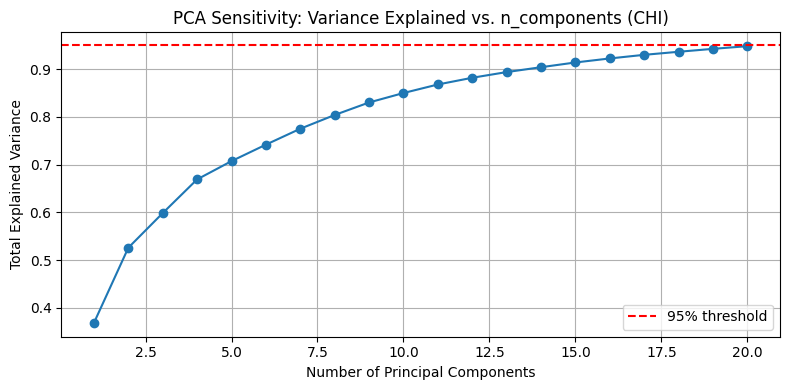

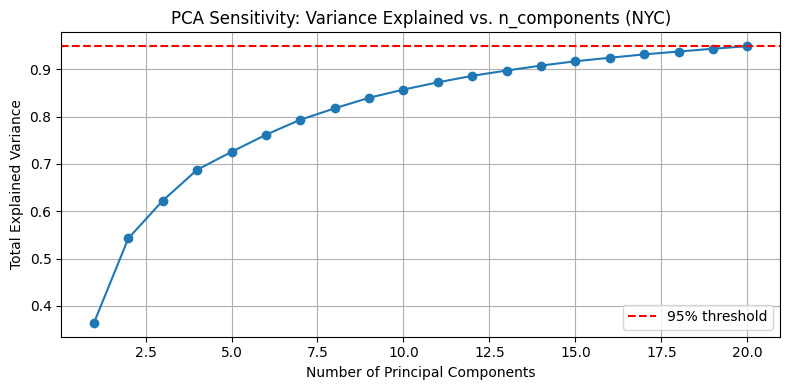

In [4]:
n_components = 20
states = ['CHI', 'NYC']
results = {}
component_range = list(range(1, n_components + 1))

for state in states:

    # Prepare and group data
    df_state = data[data['state'] == state].copy().dropna().reset_index(drop=True)
    df_state['snow_any'] = (df_state['snowfall_sum'] > 0).astype(int)
    df_state['snow_heavy'] = (df_state['snowfall_sum'] > 1.0).astype(int)
    df_state = df_state.drop(columns=['unit_id', 'snowfall_sum', 'snowfall_max'])
    df_state = df_state.groupby(['date', 'mode']).mean(numeric_only=True).reset_index()


    exclude_cols = ['date', 'state', 'daily_ridership']
    feature_cols = [col for col in df_state.columns if col not in exclude_cols]

    # One-hot encode mode
    mode_dummies = pd.get_dummies(df_state['mode'], prefix='mode', drop_first=True)

    # Select columns to scale 
    possible_binary_cols = ['is_weekend', 'is_holiday', 'is_holiday_adjacent', 'snow_any', 'snow_heavy']
    binary_cols = [col for col in possible_binary_cols if col in df_state.columns]
    to_scale = [col for col in feature_cols if col not in binary_cols + ['mode']]

    # Standardize continuous variables
    scaler = StandardScaler()
    X_scaled_part = scaler.fit_transform(df_state[to_scale])
    scaled_df = pd.DataFrame(X_scaled_part, index=df_state.index, columns=to_scale)

    # Combine Everything
    for col in binary_cols:
        scaled_df[col] = df_state[col].values    
    X_final = pd.concat([mode_dummies.reset_index(drop=True), scaled_df], axis=1)

    # Explained variance curve
    explained_var_curve = []
    for n in component_range:
        pca = PCA(n_components=n, random_state=27)
        pca.fit(X_final)
        explained_var_curve.append(pca.explained_variance_ratio_.sum())
        
    plt.figure(figsize=(8, 4))
    plt.plot(component_range, explained_var_curve, marker='o')
    plt.axhline(y=0.95, linestyle='--', color='r', label='95% threshold')
    plt.title(f"PCA Sensitivity: Variance Explained vs. n_components ({state})")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Total Explained Variance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Full PCA
    pca = PCA(n_components=n_components, random_state=27)
    X_pca = pca.fit_transform(X_final)

    

    explained_var = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(pca.n_components_)],
        'Explained Variance Ratio': pca.explained_variance_ratio_
    })

    loadings = pd.DataFrame(
        pca.components_.T,
        index=X_final.columns,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    )

    results[state] = {
        'X_pca': X_pca,
        'explained_var': explained_var,
        'loadings': loadings,
        'features': X_final,
        'sensitivity': explained_var_curve
    }

    # Export feature matrix
    X_final_comp = pd.concat([df_state[['date', 'mode', 'daily_ridership']], mode_dummies.reset_index(drop=True), scaled_df], axis=1)
    X_final_comp.to_csv(f"data/{state}_trunc.csv", index=False)


In [5]:
results['NYC']['explained_var'].head(10)

,Component,Explained Variance Ratio
0,PC1,0.364095
1,PC2,0.178677
2,PC3,0.079634
3,PC4,0.065355
4,PC5,0.037792
5,PC6,0.036171
6,PC7,0.031689
7,PC8,0.024195
8,PC9,0.022313
9,PC10,0.017268


In [7]:
results['CHI']['explained_var'].head(10)

,Component,Explained Variance Ratio
0,PC1,0.368464
1,PC2,0.157455
2,PC3,0.072539
3,PC4,0.070607
4,PC5,0.038297
5,PC6,0.034486
6,PC7,0.033343
7,PC8,0.028827
8,PC9,0.026191
9,PC10,0.019780


In [11]:
pcs = ['PC1', 'PC2', 'PC3', 'PC4']
states = ['CHI', 'NYC']

for state in states:
    print([feat for feat in results[state]['loadings'].index if 'mode_' in feat])
    for pc in pcs:
        print(state,pc)
        loadings = results[state]['loadings'][pc]
        top_features = loadings.abs().sort_values(ascending=False).head(20)
        print(top_features)

['mode_train']
CHI PC1
us_aqi_mean                 0.232481
us_aqi_pm2_5_mean           0.225657
us_aqi_pm10_mean            0.224580
us_aqi_min                  0.222195
us_aqi_pm2_5_min            0.221051
us_aqi_pm10_min             0.220463
us_aqi_pm10_max             0.217664
us_aqi_pm2_5_max            0.217554
us_aqi_max                  0.215573
us_aqi_max_bin              0.204143
us_aqi_mean_bin             0.200370
us_aqi_mean_lag             0.199585
us_aqi_min_lag              0.195285
us_aqi_min_bin              0.190331
us_aqi_max_lag              0.188829
us_aqi_max_bin_lag          0.178199
us_aqi_mean_bin_lag         0.173521
us_aqi_min_bin_lag          0.171375
us_aqi_ozone_max            0.155532
apparent_temperature_max    0.146118
Name: PC1, dtype: float64
CHI PC2
us_aqi_nitrogen_dioxide_mean    0.301010
us_aqi_ozone_min                0.295097
us_aqi_nitrogen_dioxide_min     0.285116
us_aqi_ozone_mean               0.268825
us_aqi_sulphur_dioxide_mean     0.24473